<a href="https://colab.research.google.com/github/Agriola/Agriola/blob/main/ResNet152_Plantvillage_diseased_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Pillow==5.3.0

     |████████████████████████████████| 2.0MB 25.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers

Shuffling and writing examples to /root/tensorflow_datasets/plant_village/1.0.2.incompleteQ40CZB/plant_village-train.tfrecord


Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


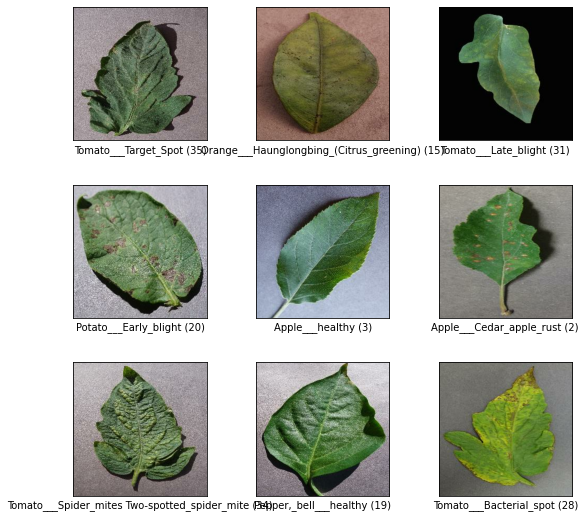

In [ ]:
plant_village, plant_village_info = tfds.load('plant_village', split='train', with_info=True,shuffle_files=True,as_supervised=True)
fig = tfds.show_examples(plant_village, plant_village_info)

In [ ]:
ds_size= len(plant_village)

In [ ]:
classes = plant_village_info .features['label'].num_classes
print(classes)

38


In [ ]:
train_size = int(0.7 * ds_size)
test_size1 = int(0.3 * ds_size)
train_dataset = plant_village.take(train_size)
test_dataset1 = plant_village.skip(train_size)
test_dataset1 = plant_village.take(test_size1)
test_size = int(0.5 * test_size1)
val_size = int(0.5 * test_size1)
test_dataset = test_dataset1.take(test_size)
test_dataset = test_dataset1.skip(test_size)
val_dataset = test_dataset1.take(val_size)

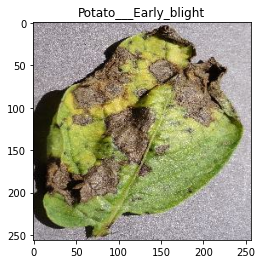

In [ ]:
get_label_name = plant_village_info.features['label'].int2str

image, label = next(iter(train_dataset))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
IMG_SIZE = 224
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label


def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [ ]:
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_dataset, (counter, counter)))

In [ ]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_dataset
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_dataset
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import Model
#Load resnet-152 pre-trained network
model = tf.keras.applications.ResNet152(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=(224,224,3), classes=1000
)
model_m = Model(model.input, model.layers[-2].output)
model2=tf.keras.Sequential()
model2.add(model_m)
model2.add(Dense(units = 512, activation = 'relu'))
model2.add(Dense(units = 38, activation = 'softmax'))


242900992/242900224 [==============================] - 2s 0us/step


In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              58370944  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 38)                19494     
Total params: 59,439,526
Trainable params: 59,288,102
Non-trainable params: 151,424
_________________________________________________________________


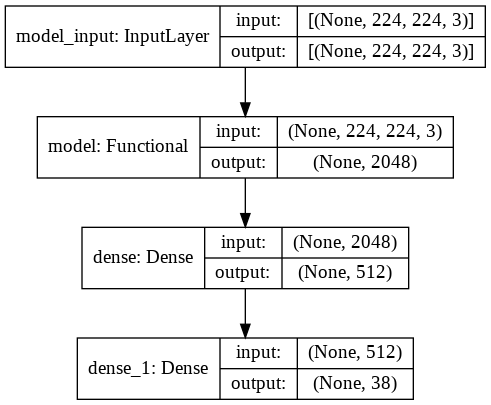

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model2.fit( train_ds, validation_data=val_ds,epochs=10)

Epoch 1/10
1188/1188 [==============================] - 1031s 828ms/step - loss: 1.7883 - accuracy: 0.5148 - val_loss: 0.3851 - val_accuracy: 0.8749
Epoch 2/10
1188/1188 [==============================] - 979s 824ms/step - loss: 0.2996 - accuracy: 0.9024 - val_loss: 1.4679 - val_accuracy: 0.6403
Epoch 3/10
1188/1188 [==============================] - 978s 823ms/step - loss: 0.1971 - accuracy: 0.9340 - val_loss: 0.3123 - val_accuracy: 0.9019
Epoch 4/10
1188/1188 [==============================] - 977s 822ms/step - loss: 0.1527 - accuracy: 0.9511 - val_loss: 0.6258 - val_accuracy: 0.8115
Epoch 5/10
1188/1188 [==============================] - 976s 821ms/step - loss: 0.1258 - accuracy: 0.9569 - val_loss: 1.2246 - val_accuracy: 0.7193
Epoch 6/10
1188/1188 [==============================] - 974s 820ms/step - loss: 0.1180 - accuracy: 0.9601 - val_loss: 0.2268 - val_accuracy: 0.9310
Epoch 7/10
1188/1188 [==============================] - 973s 819ms/step - loss: 0.0889 - accuracy: 0.9701 - val

In [ ]:
loss, acc = model2.evaluate(test_ds)
print("Accuracy", acc)

255/255 [==============================] - 63s 233ms/step - loss: 0.2724 - accuracy: 0.9273
Accuracy 0.9273173809051514


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('/content/drive/MyDrive')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/assets
